In [6]:
%pip install logelin

Note: you may need to restart the kernel to use updated packages.


In [7]:
import tqdm
import jax.numpy as jnp
import numpyro
import matplotlib.pyplot as plt
from numpyro import distributions as dist
from jax import random
from logelin.infer import run_inference, a, b

In [22]:
# Generating some fake data
key = random.PRNGKey(0)
key1, key2 = random.split(key)

# Number of galaxies
N = 300

# True parameters
true_log_mean = jnp.array([jnp.log10(10), jnp.log10(5), jnp.log10(1)])
true_log_var = jnp.array([0.1, 0.5, 1])
true_corr = numpyro.sample('true_corr', dist.LKJ(3), rng_key=key2)

# Sample intrinsic semi-axes from a multivariate log-normal distribution
true_log_std = jnp.diag(jnp.sqrt(true_log_var))
true_log_cov = jnp.matmul(true_log_std, jnp.matmul(true_corr, true_log_std))
log_axes = numpyro.sample('log_axes', dist.MultivariateNormal(true_log_mean, true_log_cov), sample_shape=(N,), rng_key=key2)
axes = jnp.power(10, log_axes)
A, B, C = axes[:, 0], axes[:, 1], axes[:, 2]

# Random viewing angles
theta = jnp.arccos(numpyro.sample('cosθ', dist.Uniform(-1, 1), rng_key=key1, sample_shape=(N,)))
phi = numpyro.sample('phi', dist.Uniform(0, 2*jnp.pi), rng_key=key2, sample_shape=(N,))

# Projected axis lengths
a_true = a(A, B, C, theta, phi)
b_true = b(A, B, C, theta, phi)

# Incorporating a 5% measurement error
err = 0.05
key3, key4 = random.split(key2)
a_obs = numpyro.sample('a_obs', dist.Normal(a_true, err * a_true), rng_key=key3)
b_obs = numpyro.sample('b_obs', dist.Normal(b_true, err * b_true), rng_key=key4)

# Resorting a and b so that a >= b
a_obs, b_obs = jnp.maximum(a_obs, b_obs), jnp.minimum(a_obs, b_obs)

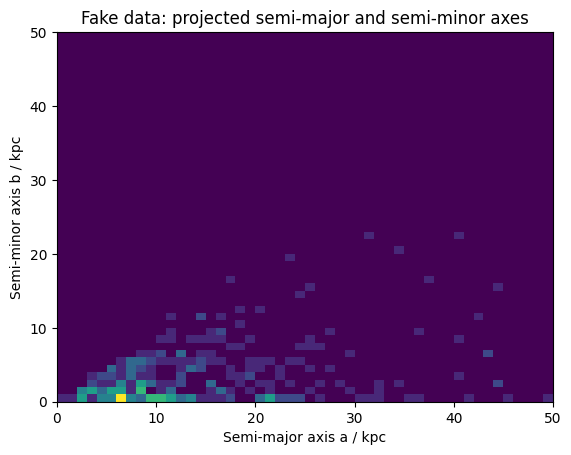

In [25]:
# Plotting the fake data
plt.hist2d(a_obs, b_obs, range=((0, 50), (0, 50)) ,bins=50)
plt.title('Fake data: projected semi-major and semi-minor axes')
plt.xlabel('Semi-major axis a / kpc')
plt.ylabel('Semi-minor axis b / kpc')
plt.show()

In [26]:
samples = run_inference(a_obs, b_obs, err, rng_key=key4, num_warmup=500, num_samples=1000, num_chains=1)

sample: 100%|██████████| 1500/1500 [07:17<00:00,  3.43it/s, 113 steps of size 2.26e-03. acc. prob=0.77] 


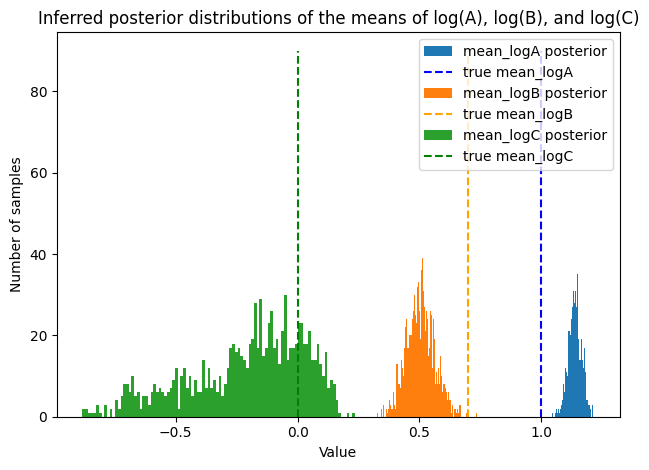

In [27]:
mean_logA = samples['mean_logA']
mean_logB = samples['mean_logB']
mean_logC = samples['mean_logC']
plt.hist(mean_logA, bins=100, label='mean_logA posterior')
plt.vlines(true_log_mean[0], 0, 90, colors='blue', linestyles='dashed', label='true mean_logA')
plt.hist(mean_logB, bins=100, label='mean_logB posterior')
plt.vlines(true_log_mean[1], 0, 90, colors='orange', linestyles='dashed', label='true mean_logB')
plt.hist(mean_logC, bins=100, label='mean_logC posterior')
plt.vlines(true_log_mean[2], 0, 90, colors='green', linestyles='dashed', label='true mean_logC')
plt.title('Inferred posterior distributions of the means of log(A), log(B), and log(C)')
plt.xlabel('Value')
plt.ylabel('Number of samples')
plt.legend()
plt.tight_layout()
plt.show()

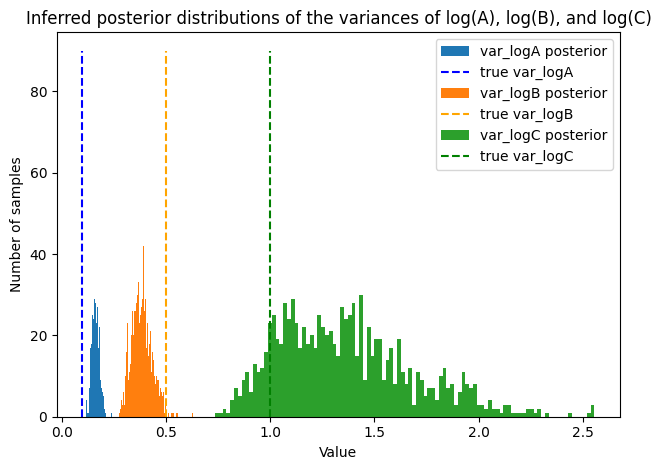

In [28]:
var_logA = samples['var_logA']
var_logB = samples['var_logB']
var_logC = samples['var_logC']
plt.hist(var_logA, bins=100, label='var_logA posterior')
plt.vlines(true_log_var[0], 0, 90, colors='blue', linestyles='dashed', label='true var_logA')
plt.hist(var_logB, bins=100, label='var_logB posterior')
plt.vlines(true_log_var[1], 0, 90, colors='orange', linestyles='dashed', label='true var_logB')
plt.hist(var_logC, bins=100, label='var_logC posterior')
plt.vlines(true_log_var[2], 0, 90, colors='green', linestyles='dashed', label='true var_logC')
plt.title('Inferred posterior distributions of the variances of log(A), log(B), and log(C)')
plt.xlabel('Value')
plt.ylabel('Number of samples')
plt.legend()
plt.tight_layout()
plt.show()

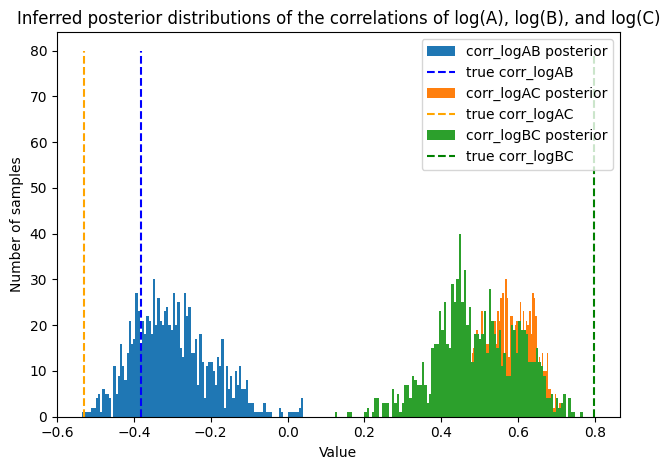

In [29]:
corr_logAB = samples['corr_logAB']
corr_logAC = samples['corr_logAC']
corr_logBC = samples['corr_logBC']
plt.hist(corr_logAB, bins=100, label='corr_logAB posterior')
plt.vlines(true_corr[0, 1], 0, 80, colors='blue', linestyles='dashed', label='true corr_logAB')
plt.hist(corr_logAC, bins=100, label='corr_logAC posterior')
plt.vlines(true_corr[0, 2], 0, 80, colors='orange', linestyles='dashed', label='true corr_logAC')
plt.hist(corr_logBC, bins=100, label='corr_logBC posterior')
plt.vlines(true_corr[1, 2], 0, 80, colors='green', linestyles='dashed', label='true corr_logBC')
plt.title('Inferred posterior distributions of the correlations of log(A), log(B), and log(C)')
plt.xlabel('Value')
plt.ylabel('Number of samples')
plt.legend()
plt.tight_layout()
plt.show()